# 初期設定

In [1]:
from typing import *
import os
from glob import glob
from datetime import datetime
import math
import random as rn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from minepy import MINE as Mine
from crypto_data_fetcher.gmo import GmoFetcher
from scipy.stats import ttest_1samp
import talib
import shap
import numba

# 機械学習ライブラリ
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, f1_score, r2_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
import joblib
import optuna

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

np.random.seed(123)
rn.seed(123)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dtype = {
    'timestamp': str,
    'open': float,
    'high': float,
    'low': float,
    'close': float,
    'volume': float}

# BTC
df = pd.read_csv('ohlcv_15min_1218_btc.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df)

df_btc_5m = pd.read_csv('ohlcv_5min_1218_btc.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df_btc_5m)

df_btc_2_5m = pd.read_csv('ohlcv_2.5min_1218_btc.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df_btc_2_5m)

df_btc_7_5m = pd.read_csv('ohlcv_7.5min_1218_btc.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df_btc_7_5m)

# ETH
df_eth = pd.read_csv('ohlcv_15min_1218_eth.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df_eth)

df_eth_5m = pd.read_csv('ohlcv_5min_1218_eth.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df_eth_5m)


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339.0
1,2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155.0
2,2019-10-01 00:30:00+00:00,8231.5,8236.0,8214.0,8236.0,7055839.0
3,2019-10-01 00:45:00+00:00,8236.0,8236.0,8220.0,8225.0,2851351.0
4,2019-10-01 01:00:00+00:00,8225.0,8235.0,8199.0,8228.5,8568631.0
...,...,...,...,...,...,...
77731,2021-12-18 22:45:00+00:00,46841.5,46857.0,46676.0,46772.0,8642827.0
77732,2021-12-18 23:00:00+00:00,46771.5,46868.0,46679.0,46826.0,11434058.0
77733,2021-12-18 23:15:00+00:00,46826.5,46835.0,46636.0,46830.0,17467704.0
77734,2021-12-18 23:30:00+00:00,46829.5,46990.5,46829.5,46942.0,8978110.0


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8253.5,8262.0,9050902.0
1,2019-10-01 00:05:00+00:00,8262.0,8266.5,8251.0,8252.5,3755054.0
2,2019-10-01 00:10:00+00:00,8252.5,8253.5,8227.0,8253.0,2402383.0
3,2019-10-01 00:15:00+00:00,8253.0,8264.0,8253.0,8255.5,2478222.0
4,2019-10-01 00:20:00+00:00,8252.5,8255.0,8226.0,8234.5,2964025.0
...,...,...,...,...,...,...
233202,2021-12-18 23:35:00+00:00,46864.0,46990.5,46864.0,46912.0,4840903.0
233203,2021-12-18 23:40:00+00:00,46914.5,46964.0,46907.5,46942.0,1416498.0
233204,2021-12-18 23:45:00+00:00,46941.5,46957.0,46911.0,46945.0,859405.0
233205,2021-12-18 23:50:00+00:00,46945.0,46960.0,46910.0,46910.0,1078433.0


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8285.0,8287.5,4718824.0
1,2019-10-01 00:02:30+00:00,8287.5,8287.5,8253.5,8262.0,4332078.0
2,2019-10-01 00:05:00+00:00,8262.0,8266.5,8252.5,8253.0,2353891.0
3,2019-10-01 00:07:30+00:00,8253.0,8260.5,8251.0,8252.5,1401163.0
4,2019-10-01 00:10:00+00:00,8252.5,8253.0,8227.0,8243.5,1461908.0
...,...,...,...,...,...,...
466408,2021-12-18 23:47:30+00:00,46925.0,46957.0,46924.5,46945.0,441787.0
466409,2021-12-18 23:50:00+00:00,46945.0,46960.0,46930.5,46959.5,246586.0
466410,2021-12-18 23:52:30+00:00,46960.0,46960.0,46910.0,46910.0,831847.0
466411,2021-12-18 23:55:00+00:00,46910.5,46910.5,46822.0,46822.0,1682686.0


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8252.5,8253.0,11404793.0
1,2019-10-01 00:07:30+00:00,8253.0,8260.5,8227.0,8253.0,3803546.0
2,2019-10-01 00:15:00+00:00,8253.0,8264.0,8240.5,8240.5,3486169.0
3,2019-10-01 00:22:30+00:00,8241.0,8243.0,8226.0,8231.5,3240986.0
4,2019-10-01 00:30:00+00:00,8231.5,8231.5,8214.0,8215.5,4429743.0
...,...,...,...,...,...,...
155467,2021-12-18 23:22:30+00:00,46746.5,46830.0,46734.0,46830.0,3624575.0
155468,2021-12-18 23:30:00+00:00,46829.5,46990.5,46829.5,46950.0,6801948.0
155469,2021-12-18 23:37:30+00:00,46950.0,46964.0,46907.5,46942.0,2176162.0
155470,2021-12-18 23:45:00+00:00,46941.5,46960.0,46911.0,46959.5,1105991.0


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,181.25,181.70,179.55,180.10,911858.0
1,2019-10-01 00:15:00+00:00,180.15,180.35,179.05,179.90,1259103.0
2,2019-10-01 00:30:00+00:00,179.90,179.90,178.65,179.05,623606.0
3,2019-10-01 00:45:00+00:00,179.10,179.10,178.65,179.05,368355.0
4,2019-10-01 01:00:00+00:00,179.05,179.15,178.30,178.80,617389.0
...,...,...,...,...,...,...
77731,2021-12-18 22:45:00+00:00,3985.30,3985.35,3967.00,3972.95,3646476.0
77732,2021-12-18 23:00:00+00:00,3973.00,3974.80,3960.05,3964.10,4487803.0
77733,2021-12-18 23:15:00+00:00,3965.55,3965.60,3944.00,3960.00,13413637.0
77734,2021-12-18 23:30:00+00:00,3960.05,3971.80,3957.15,3965.40,3089700.0


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,181.25,181.70,180.05,180.20,608289.0
1,2019-10-01 00:05:00+00:00,180.20,180.55,179.80,179.90,152752.0
2,2019-10-01 00:10:00+00:00,179.90,180.10,179.55,180.10,150817.0
3,2019-10-01 00:15:00+00:00,180.15,180.35,180.00,180.00,356446.0
4,2019-10-01 00:20:00+00:00,179.65,179.75,179.05,179.45,493927.0
...,...,...,...,...,...,...
233202,2021-12-18 23:35:00+00:00,3961.75,3971.80,3961.75,3964.00,2090534.0
233203,2021-12-18 23:40:00+00:00,3964.25,3967.55,3963.55,3965.40,639713.0
233204,2021-12-18 23:45:00+00:00,3965.40,3969.55,3963.10,3967.85,327541.0
233205,2021-12-18 23:50:00+00:00,3968.50,3968.50,3961.90,3962.40,253686.0


# 特徴量生成

In [3]:
def get_every_15min_datas(df: pd.DataFrame) -> pd.DataFrame:
    """15分ごとのにデータを整形する"""

    def parse_to_minute(timestamp):
        return timestamp.minute

    df = df.copy()
    df['temp'] = np.vectorize(parse_to_minute)(df['timestamp'])
    return df[df['temp'] % 15 == 0].drop(columns=['temp'])

In [4]:
def up_hige_size(df):
    """上ヒゲの大きさ"""
    df = df.copy()
    uphige = np.zeros(len(df))
    high = df.high.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        h = high[i]
        o = open_[i]
        c = close[i]
        if sig == 1:
            uphige[i] = (h - o) / c
        else:
            uphige[i] = (h - c) / c
    uphige = uphige/close
    return uphige

def down_hige_size(df):
    """下ヒゲの大きさ"""
    df = df.copy()
    downhige = np.zeros(len(df))
    low = df.low.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        l = low[i]
        o = open_[i]
        c = close[i]

        if sig == 1:
            downhige[i] = (c - l) / c
        else:
            downhige[i] = (o - l) / c
    downhige = downhige/close
    return downhige


def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    df['pct'] = df['close'].pct_change()  # 変化率
    # 平均足を使った戦略: https://note.com/btcml/n/n6198a3714fe5
    df['heikin_cl'] = 0.25 * (df['open'] + df['high'] + df['low'] + df['close'])
    df['heikin_op'] = df['heikin_cl'].ewm(1, adjust=False).mean().shift(1)
    for span in [5, 15, 25]:
        df[f'pct_mean{span}']= df['pct'].rolling(span).mean()  # 変化率の偏差
        df[f'pct_std{span}']= df['pct'].rolling(span).std()  # 変化率の偏差
        df[f'heikin_cl_mean{span}'] = df['heikin_cl'].rolling(span).mean()
        df[f'heikin_cl_std{span}'] = df['heikin_cl'].rolling(span).std()
        df[f'heikin_op_mean{span}'] = df['heikin_op'].rolling(span).mean()
        df[f'heikin_op_std{span}'] = df['heikin_op'].rolling(span).std()

    return df


def calc_fine_timescale_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    hilo = (df['high'] + df['low']) / 2
    

    df['pct'] = df['close'].pct_change()  # 変化率
    df['pct_mean5']= df['pct'].rolling(5).std()  # 変化率の平均
    df['pct_std5']= df['pct'].rolling(5).std()  # 変化率の偏差
    
    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    # 平均足を使った戦略: https://note.com/btcml/n/n6198a3714fe5
    df['heikin_cl'] = 0.25 * (df['open'] + df['high'] + df['low'] + df['close'])
    df['heikin_op'] = df['heikin_cl'].ewm(1, adjust=False).mean().shift(1)
    df['heikin_cl_mean5'] = df['heikin_cl'].rolling(5).mean()
    df['heikin_cl_std5'] = df['heikin_cl'].rolling(5).std()
    df['heikin_op_mean5'] = df['heikin_op'].rolling(5).mean()
    df['heikin_op_std5'] = df['heikin_op'].rolling(5).std()


    return df



df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = calc_features(df)

df_btc_5mf = calc_fine_timescale_features(df_btc_5m)
df_btc_2_5mf = calc_fine_timescale_features(df_btc_2_5m)
df_btc_7_5mf = calc_fine_timescale_features(df_btc_7_5m)
df_ethf = calc_features(df_eth)
df_eth_5mf = calc_fine_timescale_features(df_eth_5m)


df = pd.merge(df, get_every_15min_datas(df_btc_5mf), on='timestamp', suffixes=['', '_btc5m'])
df = pd.merge(df, get_every_15min_datas(df_btc_2_5mf), on='timestamp', suffixes=['', '_btc2_5m'])
df = pd.merge(df, get_every_15min_datas(df_btc_7_5mf), on='timestamp', suffixes=['', '_btc7_5m'])
df = pd.merge(df, df_ethf, on='timestamp', suffixes=['', '_eth'])
df = pd.merge(df, get_every_15min_datas(df_eth_5mf), on='timestamp', suffixes=['', '_eth5m'])
df = df.set_index('timestamp')


display(df)

print('NaNが含まれている行数:', df.isnull().any(axis=1).sum())

df.to_pickle('df_features.pkl')

,open,high,low,close,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,uphige_size,downhige_size,pct,heikin_cl,heikin_op,pct_mean5,pct_std5,heikin_cl_mean5,heikin_cl_std5,heikin_op_mean5,heikin_op_std5,pct_mean15,pct_std15,heikin_cl_mean15,heikin_cl_std15,heikin_op_mean15,heikin_op_std15,pct_mean25,pct_std25,heikin_cl_mean25,heikin_cl_std25,heikin_op_mean25,heikin_op_std25,open_btc5m,high_btc5m,low_btc5m,close_btc5m,volume_btc5m,pct_btc5m,pct_mean5_btc5m,pct_std5_btc5m,uphige_size_btc5m,downhige_size_btc5m,heikin_cl_btc5m,heikin_op_btc5m,heikin_cl_mean5_btc5m,heikin_cl_std5_btc5m,heikin_op_mean5_btc5m,heikin_op_std5_btc5m,open_btc2_5m,high_btc2_5m,low_btc2_5m,close_btc2_5m,volume_btc2_5m,pct_btc2_5m,pct_mean5_btc2_5m,pct_std5_btc2_5m,uphige_size_btc2_5m,downhige_size_btc2_5m,heikin_cl_btc2_5m,heikin_op_btc2_5m,heikin_cl_mean5_btc2_5m,heikin_cl_std5_btc2_5m,heikin_op_mean5_btc2_5m,heikin_op_std5_btc2_5m,open_btc7_5m,high_btc7_5m,low_btc7_5m,close_btc7_5m,volume_btc7_5m,pct_btc7_5m,pct_mean5_btc7_5m,pct_std5_btc7_5m,uphige_size_btc7_5m,downhige_size_btc7_5m,heikin_cl_btc7_5m,heikin_op_btc7_5m,heikin_cl_mean5_btc7_5m,heikin_cl_std5_btc7_5m,heikin_op_mean5_btc7_5m,heikin_op_std5_btc7_5m,open_eth,high_eth,low_eth,close_eth,volume_eth,BBANDS_upperband_eth,BBANDS_middleband_eth,BBANDS_lowerband_eth,DEMA_eth,EMA_eth,HT_TRENDLINE_eth,KAMA_eth,MA_eth,MIDPOINT_eth,SMA_eth,T3_eth,TEMA_eth,TRIMA_eth,WMA_eth,ADX_eth,ADXR_eth,APO_eth,AROON_aroondown_eth,AROON_aroonup_eth,AROONOSC_eth,BOP_eth,CCI_eth,DX_eth,MACD_macd_eth,MACD_macdsignal_eth,MACD_macdhist_eth,MFI_eth,MINUS_DI_eth,MINUS_DM_eth,MOM_eth,PLUS_DI_eth,PLUS_DM_eth,RSI_eth,STOCH_slowk_eth,STOCH_slowd_eth,STOCHF_fastk_eth,STOCHF_fastd_eth,STOCHRSI_fastk_eth,STOCHRSI_fastd_eth,TRIX_eth,ULTOSC_eth,WILLR_eth,AD_eth,ADOSC_eth,OBV_eth,ATR_eth,NATR_eth,TRANGE_eth,HT_DCPERIOD_eth,HT_DCPHASE_eth,HT_PHASOR_inphase_eth,HT_PHASOR_quadrature_eth,HT_SINE_sine_eth,HT_SINE_leadsine_eth,HT_TRENDMODE_eth,BETA_eth,CORREL_eth,LINEARREG_eth,LINEARREG_ANGLE_eth,LINEARREG_INTERCEPT_eth,LINEARREG_SLOPE_eth,STDDEV_eth,uphige_size_eth,downhige_size_eth,pct_eth,heikin_cl_eth,heikin_op_eth,pct_mean5_eth,pct_std5_eth,heikin_cl_mean5_eth,heikin_cl_std5_eth,heikin_op_mean5_eth,heikin_op_std5_eth,pct_mean15_eth,pct_std15_eth,heikin_cl_mean15_eth,heikin_cl_std15_eth,heikin_op_mean15_eth,heikin_op_std15_eth,pct_mean25_eth,pct_std25_eth,heikin_cl_mean25_eth,heikin_cl_std25_eth,heikin_op_mean25_eth,heikin_op_std25_eth,open_eth5m,high_eth5m,low_eth5m,close_eth5m,volume_eth5m,pct_eth5m,pct_mean5_eth5m,pct_std5_eth5m,uphige_size_eth5m,downhige_size_eth5m,heikin_cl_eth5m,heikin_op_eth5m,heikin_cl_mean5_eth5m,heikin_cl_std5_eth5m,heikin_op_mean5_eth5m,heikin_op_std5_eth5m
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339.0,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.393805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.209811e+06,NaN,1.520834e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.239722e-07,3.817242e-07,NaN,8279.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8297.5,8340.0,8253.5,8262.

NaNが含まれている行数: 88


In [5]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',

    'pct',
    'pct_mean5',
    'pct_mean15',
    'pct_mean25',
    'pct_std5',
    'pct_std15',
    'pct_std25',
    'uphige_size',
    'downhige_size',

    'heikin_cl',
    'heikin_op',
    'heikin_cl_mean5',
    'heikin_op_mean5',
    'heikin_cl_mean15',
    'heikin_op_mean15',
    'heikin_cl_mean25',
    'heikin_op_mean25',
    'heikin_cl_std5',
    'heikin_op_std5',
    'heikin_cl_std15',
    'heikin_op_std15',
    'heikin_cl_std25',
    'heikin_op_std25',
])

fine_features = [
    'pct',
    'pct_mean5',
    'pct_std5',
    'uphige_size',
    'downhige_size',
    'heikin_cl',
    'heikin_op',
    'heikin_cl_mean5',
    'heikin_op_mean5',
    'heikin_cl_std5',
    'heikin_op_std5',
]

features_btc5m = [feature + '_btc5m' for feature in fine_features]
features_btc2_5m = [feature + '_btc2_5m' for feature in fine_features]
features_btc7_5m = [feature + '_btc7_5m' for feature in fine_features]
features_eth = [feature + '_eth' for feature in features]
features_eth5m = [feature + '_eth5m' for feature in fine_features]

features = features + features_btc5m + features_btc2_5m + features_btc7_5m + features_eth + features_eth5m

print(features)
print('num of features', len(features))

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA', 'downhige_size', 'heikin_cl', 'heikin_cl_mean15', 'heikin_cl_mean25', 'heikin_cl_mean5', 'heikin_cl_std15', 'heikin_cl_std25', 'heikin_cl_std5', 'heikin_op', 'heikin_op_mean15', 'heikin_op_mean25', 'heikin_op_mean5', 'heikin_op_std15', 'heikin_op_std25', 'heikin_op_std5', 'pct', 'pct_mean15', 'pct_mean25', 'pct_mean5', 'pct_std15', 'pct_std25', 'pct_std5', 'uphige_size', 'pct_btc5m', 'pct_mean5_btc5m', 'pct_std5_btc5m', 'uphige_size_btc5m', 'downh

# FEP計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


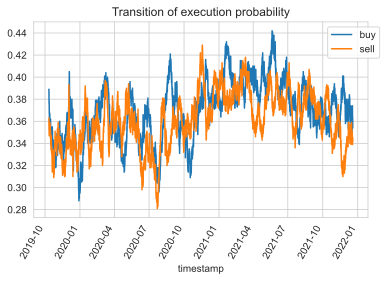

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


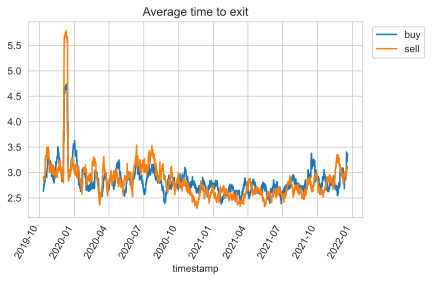

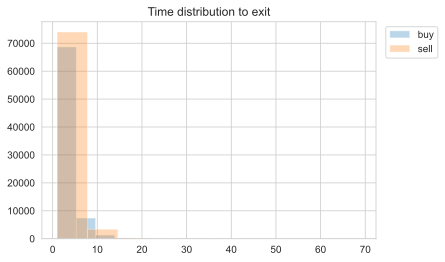

毎時刻、この執行方法でトレードした場合の累積リターン


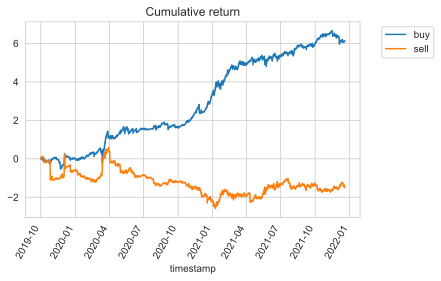

In [6]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.5

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_executed'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Transition of execution probability')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_fet'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Average time to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('Time distribution to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy', rot=60)
df['y_sell'].cumsum().plot(label='sell', rot=60)
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

# ML

In [9]:
def show_lgb_feature_importances(lgb_model):
    ranking = np.argsort(-lgb_model.feature_importances_)  # 重要度のindexを降順で取得
    f, ax = plt.subplots(figsize=(15, 35))
    var_ = []
    for index in ranking:
        var_.append(features[index])
    # x は特徴量の重要度
    # yは特徴量の名前
    sns.barplot(x=lgb_model.feature_importances_[ranking], y =var_, orient='h')
    ax.set_xlabel("lightGBM feature importance")
    plt.tight_layout()
    plt.show()
    return var_


# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)


def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)


def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred


def show_cum_ret(df):
    # df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
    df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(rot=60, title='buy', color=colors[1])
    plt.show()
    # df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='sell', rot=60)
    df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(rot=60, title='sell', color=colors[0])
    plt.show()
    # (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
    (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(rot=60, title='buy + sell', color=colors[2])
    plt.show()

    # df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
    df['cum_ret'] = (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


@numba.njit
def backtest(
    cl=None, hi=None, lo=None, pips=None,
    buy_entry=None, sell_entry=None,
    buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]  # 既にエントリ済みならエントリしない
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]  # 既にエントリ済みならエントリしない
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            # 実際の指値は終値からいくらかずらした値(ATRを使って終値からずらした指値)だった。
            # つまり、実際は終値よりもちょっとだけ良い値段でエントリしたり決済したはず、その分を先にcostとして計算しておき、後にまとめて調整する仕組み。
            # costと呼んでいるが、実際には終値からの調整幅を記録した値、と考えるとすっきりしそう。
            # ポジションがある限り終値の差分を計算していくので、含み益、あるいは含み損を持ち越している。
            # また、決済の指値は機械学習の判定は関係なく常に出している。
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

def show_test_result(df):
    df = df.copy()

    df['cum_ret'].plot(rot=60)
    plt.title('Cumulative return')
    plt.show()

    print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
    print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
    df['poss'].plot(rot=60)
    plt.title('Position Changes')
    plt.show()

    print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
    df['poss'].rolling(1000).mean().plot(rot=60)
    plt.title('Changes in position averages')
    plt.show()

    print('取引量(ポジション差分の絶対値)の累積です。')
    print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
    df['poss'].diff(1).abs().dropna().cumsum().plot(rot=60)
    plt.title('Cumulative trading volume')
    plt.show()

    print('t検定')
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0)
    print('t値 {}'.format(t))
    print('p値 {}'.format(p))

    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

    print('result: ', df['cum_ret'][-1])

# ハイパーパラメータチューニング

In [10]:
SAVE_BEST_PARAM_DIR = 'production_best_params_dir'
os.makedirs(SAVE_BEST_PARAM_DIR, exist_ok=True)


def calc_objective_p(df):
    df = df.copy()
    df['cum_ret'], _ = backtest(
        cl=df['close'].values,
        buy_entry=df['y_pred_buy'].values > 0,
        sell_entry=df['y_pred_sell'].values > 0,
        buy_cost=df['buy_cost'].values,
        sell_cost=df['sell_cost'].values)
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    p_error = calc_p_mean_type1_error_rate(p_mean, p_mean_n)
    return p_error


def show_shap(df, model):
    explainer = shap.Explainer(model)  # 学習済みモデルを与える
    shap_values = explainer.shap_values(df[features])  # 学習データでSHAP値を計算

    # 目的変数と各特徴量の相関関係を表示
    shap.summary_plot(shap_values, df[features])
    # 目的変数に対する特徴量の寄与度を表示
    shap.summary_plot(shap_values, df[features], plot_type="bar")

## 回帰

#### gbdt

In [12]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

df_train = df.copy()

cv_indicies = list(KFold().split(df_train))

def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_error = calc_objective_p(df=df)
    return p_error


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=200)

best_params = study.best_params
best_score = study.best_value

np.save(os.path.join(SAVE_BEST_PARAM_DIR, 'gbdt.npy'), best_params)

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

[I 2021-12-23 11:29:30,854] A new study created in memory with name: no-name-9b5389c3-66ad-491c-a1c3-fe3b3135118c
[I 2021-12-23 11:30:08,728] Trial 0 finished with value: 0.049212753440351795 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.049212753440351795.
[I 2021-12-23 11:30:59,813] Trial 1 finished with value: 0.149539738253256 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 0 with value: 0.049212753440351795.
[I 2021-12-23 11:31:37,566] Trial 2 finished with value: 0.04279428866080186 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 2 with value: 0.04279428866080186.
[I

best score: 3.9915585254605134e-05
best params: {'reg_alpha': 0.5477482489453085, 'reg_lambda': 1.42975848489259e-07, 'learning_rate': 0.32684275467974006, 'min_child_samples': 41, 'max_depth': 6}


#### dart

In [13]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

df_train = df.copy()

cv_indicies = list(KFold().split(df_train))

def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMRegressor(boosting_type='dart', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_error = calc_objective_p(df=df)
    return p_error


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=200)

best_params = study.best_params
best_score = study.best_value

np.save(os.path.join(SAVE_BEST_PARAM_DIR, 'dart.npy'), best_params)

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

[I 2021-12-23 12:35:12,230] A new study created in memory with name: no-name-4725df6c-82f8-438d-ac32-c18ef87c1634
[I 2021-12-23 12:35:32,891] Trial 0 finished with value: 0.04363908942684028 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.04363908942684028.
[I 2021-12-23 12:35:57,488] Trial 1 finished with value: 0.007452766667469358 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 1 with value: 0.007452766667469358.
[I 2021-12-23 12:36:17,800] Trial 2 finished with value: 0.11105054470624812 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 1 with value: 0.007452766667469358.


best score: 7.207103915864649e-06
best params: {'reg_alpha': 0.3896254235183326, 'reg_lambda': 2.013034588567665, 'learning_rate': 0.20709734407482874, 'min_child_samples': 34, 'max_depth': 13}


#### goss

In [15]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

df_train = df.copy()

cv_indicies = list(KFold().split(df_train))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMRegressor(boosting_type='goss', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_error = calc_objective_p(df=df)
    return p_error


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=200)

best_params = study.best_params
best_score = study.best_value

np.save(os.path.join(SAVE_BEST_PARAM_DIR, 'goss.npy'), best_params)

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

[I 2021-12-23 14:00:12,573] A new study created in memory with name: no-name-5a86e7f7-cc3c-4d67-ad3e-b113d643e302
[I 2021-12-23 14:00:28,568] Trial 0 finished with value: 0.0072845161054107144 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.0072845161054107144.
[I 2021-12-23 14:00:47,732] Trial 1 finished with value: 0.5904876177616487 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 0 with value: 0.0072845161054107144.
[I 2021-12-23 14:01:03,576] Trial 2 finished with value: 0.016639704737370475 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 0 with value: 0.0072845161054107

best score: 1.473553672895174e-06
best params: {'reg_alpha': 0.14789944592645168, 'reg_lambda': 2.0755261889831775e-08, 'learning_rate': 0.1451459243575903, 'min_child_samples': 17, 'max_depth': 5}


## 分類

In [14]:
def my_cross_val_predict_class(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], np.sign(y[train_idx]), sample_weight=np.abs(y[train_idx]))
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

#### gbdt_class

In [16]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

df_train = df.copy()

cv_indicies = list(KFold().split(df_train))


def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict_class(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict_class(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_error = calc_objective_p(df=df)
    return p_error


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=200)

best_params = study.best_params
best_score = study.best_value

np.save(os.path.join(SAVE_BEST_PARAM_DIR, 'gbdt_class.npy'), best_params)

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

[I 2021-12-23 15:01:50,428] A new study created in memory with name: no-name-6910114c-0cd1-4b9c-ab82-05dc38b4f734
[I 2021-12-23 15:02:19,072] Trial 0 finished with value: 0.00185726909947643 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.00185726909947643.
[I 2021-12-23 15:03:04,756] Trial 1 finished with value: 0.03356208895656259 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 0 with value: 0.00185726909947643.
[I 2021-12-23 15:03:34,810] Trial 2 finished with value: 0.07944609310294926 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 0 with value: 0.00185726909947643.
[I 

#### dart_class

In [ ]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

df_train = df.copy()

cv_indicies = list(KFold().split(df_train))


def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMClassifier(boosting_type='dart', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict_class(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict_class(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_error = calc_objective_p(df=df)
    return p_error


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=200)

best_params = study.best_params
best_score = study.best_value

np.save(os.path.join(SAVE_BEST_PARAM_DIR, 'dart_class.npy'), best_params)

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

#### goss_class

In [ ]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

df_train = df.copy()

cv_indicies = list(KFold().split(df_train))


def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMClassifier(boosting_type='goss', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict_class(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict_class(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_error = calc_objective_p(df=df)
    return p_error


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=200)

best_params = study.best_params
best_score = study.best_value

np.save(os.path.join(SAVE_BEST_PARAM_DIR, 'goss_class.npy'), best_params)

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

In [ ]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

gbdt_params : Dict[str, float] = np.load(os.path.join(SAVE_BEST_PARAM_DIR, 'gbdt.npy'), allow_pickle='TRUE').item()
dart_params : Dict[str, float] = np.load(os.path.join(SAVE_BEST_PARAM_DIR, 'dart.npy'), allow_pickle='TRUE').item()
goss_params : Dict[str, float] = np.load(os.path.join(SAVE_BEST_PARAM_DIR, 'goss.npy'), allow_pickle='TRUE').item()
gbdt_class_params : Dict[str, float] = np.load(os.path.join(SAVE_BEST_PARAM_DIR, 'gbdt_class.npy'), allow_pickle='TRUE').item()
dart_class_params : Dict[str, float] = np.load(os.path.join(SAVE_BEST_PARAM_DIR, 'dart_class.npy'), allow_pickle='TRUE').item()
goss_class_params : Dict[str, float] = np.load(os.path.join(SAVE_BEST_PARAM_DIR, 'goss_class.npy'), allow_pickle='TRUE').item()

regression_models = {}
classification_models = {}

regression_models['gbdt'] = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **gbdt_params)
regression_models['dart'] = lgb.LGBMRegressor(boosting_type='dart', random_state=1, **dart_params)
regression_models['goss'] = lgb.LGBMRegressor(boosting_type='goss', random_state=1, **goss_params)
regression_models['ridge'] =  RidgeCV(alphas=np.logspace(-7, 7, num=20))
classification_models['gbdt'] = lgb.LGBMClassifier(boosting_type='gbdt', random_state=1, **gbdt_class_params)
classification_models['dart'] = lgb.LGBMClassifier(boosting_type='dart', random_state=1, **dart_class_params)
classification_models['goss'] = lgb.LGBMClassifier(boosting_type='goss', random_state=1, **goss_class_params)


MODEL_SAVE_DIR = 'production_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

for name, model in regression_models.items():
    model.fit(df[features], df['y_buy'])
    joblib.dump(model, os.path.join(MODEL_SAVE_DIR, f'{name}_buy.xy'), compress=True)
    model.fit(df[features], df['y_sell'])
    joblib.dump(model, os.path.join(MODEL_SAVE_DIR, f'{name}_sell.xy'), compress=True)

for name, model in classification_models.items():
    model.fit(df[features], np.sign(df['y_buy']), sample_weight=np.abs(df['y_buy']))
    joblib.dump(model, os.path.join(MODEL_SAVE_DIR, f'{name}_buy.xy'), compress=True)
    model.fit(df[features], np.sign(df['y_sell']), sample_weight=np.abs(df['y_sell']))
    joblib.dump(model, os.path.join(MODEL_SAVE_DIR, f'{name}_sell.xy'), compress=True)

